# JP Data Cleaning

Going to explore the locational columns and make a couple of functions to tidy them up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X_raw = pd.read_csv('../data/train_data.csv', dtype={'id': object})
y_raw = pd.read_csv('../data/train_targets.csv', dtype={'id': object})

# Join the two tables using their 'id' column
df = y_raw.set_index('id').join(X_raw.set_index('id'))

UNASSIGNED -  'num_private', 'basin', 'population'

IGNORE - 'id', 'recorded_by', 'wpt_name'

subgroups of 'region' - 'subvillage', 'region_code', 'district_code', 'ward'

In [167]:
df.ward.value_counts()

Igosi        307
Imalinyi     252
Siha Kati    232
Mdandu       231
Nduruma      217
            ... 
Matarawe       1
Mkumbi         1
Kitete         1
Nsemulwa       1
Chinugulu      1
Name: ward, Length: 2092, dtype: int64

**LGA column seems to have some hidden info in it**

it seems to be a more specific district list, with some entries being marked 'urban' or 'rural'

i'm going to try to separate these entries out using the following encoding

In [163]:
def encode_lga(df):
    '''
    encodes the 'lga' column into the values
    'rural', 'urban', and 'other'
    
    returns DataFrame with column 'lga_coded'
    '''
    
    lga_e = []
    
    for entry in df.lga:
        key = entry.split()[-1]
        if key == 'Rural':
            lga_e.append('rural')
        elif key == 'Urban':
            lga_e.append('urban')
        else:
            lga_e.append('other')
    
    df['lga_coded'] = lga_e
    return df.drop('lga', axis=1)

Now let's see how many of each value we get

In [102]:
encode_lga(df).lga_coded.value_counts()

other    48165
rural     9552
urban     1683
Name: lga_coded, dtype: int64

Maybe this is not too good, although it does highlight a lot of water points as rural

Next i'm going to make a function to bin the different regions

In [168]:
def encode_region(df, num_of_bins=5):
    '''
    Takes in Tanzania Water Point Data, groups by region,
    sorts regions by proportion of non-functional wells,
    and bins them in equally-sized bins according to
    num_of_bins parameter
    
    
    returns: DataFrame with 'region_bins' column added
             and with 'region' and 'region_code' columns dropped
    '''
    
    #group DataFrame by region and count each type of waterpoint
    reg = df.groupby('region')['status_group'].value_counts().unstack()

    #calculate proportion of non-functional waterpoints in each region
    reg['total'] = reg.sum(axis=1)
    reg['non'] = reg['non functional'] / reg['total']

    #sort by that proportion
    reg = reg.sort_values('non')

    #sort regions into specified number of equally wide bins
    bin_labels = list(range(num_of_bins))
    reg['region_bins'] = pd.cut(reg.non, bins=num_of_bins,
                          labels=bin_labels)
    codes = reg.region_bins
        
    #return bin numbers attached to dataframe
    return df.join(codes, on='region').drop(['region','region_code'], axis=1)

In [162]:
encode_region(df, 6)['region_bins'].value_counts()

2    19783
1    13760
0     8644
3     8201
4     5736
5     3276
Name: region_bins, dtype: int64

### That's nice

In [149]:
pop_no_0 = df[df.population != 0]
pop_0 = df[df.population == 0]

In [150]:
pd.concat([pop_0.status_group.value_counts(),pop_no_0.status_group.value_counts()], axis=1)

,status_group,status_group
functional,11274,20985
non functional,8332,14492
functional needs repair,1775,2542


In [151]:
pop_no_0 = pop_no_0[['status_group', 'population']]
pop_0 = pop_0[['status_group', 'population']]

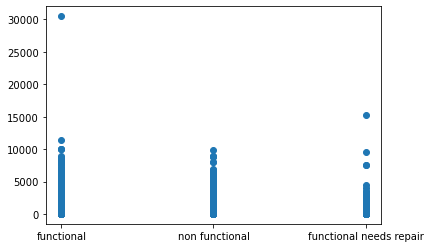

In [152]:
plt.scatter(pop_no_0.status_group, pop_no_0.population)

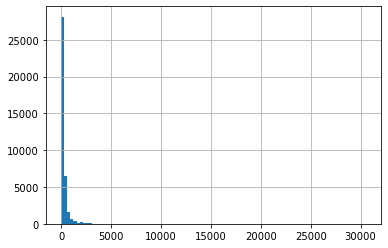

In [154]:
pop_no_0.population.hist(bins=100)

In [166]:
pop_0.shape

(21381, 2)